In [1]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense,Dropout,CuDNNLSTM,BatchNormalization
from keras.layers import Conv1D,MaxPooling1D,Flatten
from keras.layers.embeddings import Embedding
import numpy as np

Using TensorFlow backend.


In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the Signals (Input Data)


In [0]:
import io
import os

def load_data(incoming):
  path="drive/My Drive/Data/Human_activity_recognition" +'/'+ incoming
  print(path)
  files=os.listdir(path)
  print(files)
  signals_data = []

  for file in files:
    filename=path+'/'+file
    df=pd.read_csv(filename, delim_whitespace=True, header=None)
    df=(df-df.mean())/(df.max()-df.min())
    signals_data.append(df.as_matrix())
    
  # Transpose is used to change the dimensionality of the output,
  # aggregating the signals by combination of sample/timestep.
  # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
  return np.transpose(signals_data, (1, 2, 0)) 

In [4]:
X_train = load_data('Train')
X_test = load_data('Test')
print(X_train.shape)
print(X_test.shape)

drive/My Drive/Data/Human_activity_recognition/Train
['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt', 'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']
drive/My Drive/Data/Human_activity_recognition/Test
['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt', 'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']
(7352, 128, 9)
(2947, 128, 9)


### Fucntion for Confusion Matrix

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Utility function to print the confusion matrix
def confusion_matrix_cnn(Y_true, Y_pred,activities):
    Y_true = pd.Series([activities[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([activities[y] for y in np.argmax(Y_pred, axis=1)])

    #return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
    return confusion_matrix(Y_true, Y_pred)

 ## Loading the outputs

In [0]:
def load_op(incoming):
  """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
  path="drive/My Drive/Data/Human_activity_recognition" +'/'+ incoming +'.txt'
  
  df=pd.read_csv(path, delim_whitespace=True, header=None)[0]
  
  return df

In [7]:
y_train=load_op('y_train')
y_test=load_op('y_test')
print(y_train.shape)
print(y_test.shape)

(7352,)
(2947,)


## Loading the Output labels by spliting into Static and Dynamic 


1.  walking, up, down -- dynamic
2.   sitting standing lying -- static 



In [0]:
def load_op_2(incoming):
  """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
  path="drive/My Drive/Data/Human_activity_recognition" +'/'+ incoming +'.txt'
  
  df=pd.read_csv(path, delim_whitespace=True, header=None)[0]
  df[df<=3] = 0
  df[df>3] = 1
  return pd.get_dummies(df).as_matrix()

In [9]:
y_train_2=load_op_2('y_train')
y_test_2=load_op_2('y_test')
print(y_train_2.shape)
print(y_test_2.shape)

(7352, 2)
(2947, 2)


## Model for classifying data into Static and Dynamic activities

In [10]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train_2, epochs=10, batch_size=16,validation_data=(X_test, y_test_2))

W0701 06:19:06.045631 139820246591360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 06:19:06.062525 139820246591360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 06:19:06.065220 139820246591360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0701 06:19:06.103579 139820246591360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0701 06:19:06.114201 

Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 5s 728us/step - loss: 0.0342 - acc: 0.9818 - val_loss: 0.1251 - val_acc: 0.9830
Epoch 2/10
7352/7352 [==============================] - 2s 315us/step - loss: 0.0054 - acc: 0.9978 - val_loss: 0.0116 - val_acc: 0.9969
Epoch 3/10
7352/7352 [==============================] - 2s 315us/step - loss: 1.0371e-04 - acc: 1.0000 - val_loss: 0.0097 - val_acc: 0.9969
Epoch 4/10
7352/7352 [==============================] - 2s 317us/step - loss: 4.8041e-05 - acc: 1.0000 - val_loss: 0.0107 - val_acc: 0.9969
Epoch 5/10
7352/7352 [==============================] - 2s 318us/step - loss: 2.8909e-05 - acc: 1.0000 - val_loss: 0.0116 - val_acc: 0.9966
Epoch 6/10
7352/7352 [==============================] - 2s 317us/step - loss: 5.4076e-05 - acc: 1.0000 - val_loss: 0.0152 - val_acc: 0.9963
Epoch 7/10
7352/7352 [==============================] - 2s 315us/step - loss: 1.0308e-05 - acc: 1.0000 - val_loss: 0.011

## Save the 2 class classification model 

In [0]:
model.save('drive/My Drive/Data/Human_activity_recognition/model_2class.h5')

## Classificaton of Static activities

In [0]:
def load_op_stat(incoming):
  """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
  path="drive/My Drive/Data/Human_activity_recognition" +'/'+ incoming +'.txt'
  
  df=pd.read_csv(path, delim_whitespace=True, header=None)[0]
  df_subset=df>3
  df=df[df_subset]
  return pd.get_dummies(df).as_matrix(),df_subset

In [13]:
y_train_stat,x_train_size=load_op_stat('y_train')
y_test_stat,x_test_size=load_op_stat('y_test')
X_train_stat=X_train[x_train_size]
X_test_stat=X_test[x_test_size]
print(y_train_stat.shape)
print(y_test_stat.shape)
print(X_test_stat.shape)
print(X_train_stat.shape)


(4067, 3)
(1560, 3)
(1560, 128, 9)
(4067, 128, 9)


## Model for Static Activities 

In [14]:
  model_stat = Sequential()
  model_stat.add(Conv1D(filters=64, kernel_size=5,padding='same', activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
  model_stat.add(Conv1D(filters=32, kernel_size=3,padding='same', activation='relu',kernel_initializer='he_uniform'))
  model_stat.add(Dropout(0.6))
  model_stat.add(MaxPooling1D(pool_size=1,strides=1))

  model_stat.add(Flatten())
  model_stat.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
  model_stat.add(BatchNormalization()) 
  model_stat.add(Dropout(0.6))

  model_stat.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
  model_stat.add(BatchNormalization()) 
  model_stat.add(Dropout(0.6))

  model_stat.add(Dense(3, activation='softmax'))

  model_stat.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  model_stat.fit(X_train_stat,y_train_stat, epochs=30, batch_size=16,validation_data=(X_test_stat, y_test_stat))


W0701 06:19:33.171852 139820246591360 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0701 06:19:33.293424 139820246591360 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0701 06:19:33.521520 139820246591360 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 4067 samples, validate on 1560 samples
Epoch 1/30
4067/4067 [==============================] - 3s 790us/step - loss: 0.6028 - acc: 0.7829 - val_loss: 0.3360 - val_acc: 0.8885
Epoch 2/30
4067/4067 [==============================] - 2s 473us/step - loss: 0.3580 - acc: 0.8766 - val_loss: 0.3322 - val_acc: 0.8731
Epoch 3/30
4067/4067 [==============================] - 2s 481us/step - loss: 0.3004 - acc: 0.8913 - val_loss: 0.3130 - val_acc: 0.8833
Epoch 4/30
4067/4067 [==============================] - 2s 484us/step - loss: 0.2920 - acc: 0.8945 - val_loss: 0.2713 - val_acc: 0.8846
Epoch 5/30
4067/4067 [==============================] - 2s 489us/step - loss: 0.2503 - acc: 0.9063 - val_loss: 0.2819 - val_acc: 0.8929
Epoch 6/30
4067/4067 [==============================] - 2s 487us/step - loss: 0.2617 - acc: 0.9063 - val_loss: 0.2992 - val_acc: 0.8872
Epoch 7/30
4067/4067 [==============================] - 2s 480us/step - loss: 0.2467 - acc: 0.9115 - val_loss: 0.2784 - val_acc: 0.8853


In [21]:
activites_stat = {
    0: 'SITTING',
    1: 'STANDING',
    2: 'LAYING',
}

# Confusion Matrix
print(confusion_matrix_cnn(y_test_stat, model_stat.predict(X_test_stat),activites_stat))

[[537   0   0]
 [  5 424  62]
 [  0  73 459]]


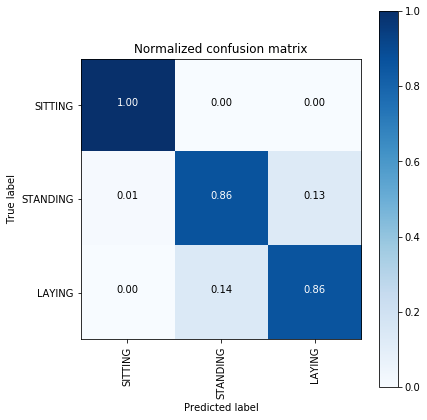

In [23]:
plt.figure(figsize=(6,6))
cm = confusion_matrix_cnn(y_test_stat, model_stat.predict(X_test_stat),activites_stat)
plot_confusion_matrix(cm, classes=['SITTING','STANDING','LAYING'], normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Blues)
plt.show()

In [0]:
model_stat.save('drive/My Drive/Data/Human_activity_recognition/model_stat_class.h5')

## Output For Dynamic Activities



In [0]:
def load_op_dyn(incoming):
  """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
  path="drive/My Drive/Data/Human_activity_recognition" +'/'+ incoming +'.txt'
  
  df=pd.read_csv(path, delim_whitespace=True, header=None)[0]
  df_subset=df<=3
  df=df[df_subset]
  return pd.get_dummies(df).as_matrix(),df_subset

In [26]:
y_train_dyn,x_train_size=load_op_dyn('y_train')
y_test_dyn,x_test_size=load_op_dyn('y_test')
X_train_dyn=X_train[x_train_size]
X_test_dyn=X_test[x_test_size]
print(y_train_dyn.shape)
print(y_test_dyn.shape)
print(X_test_dyn.shape)
print(X_train_dyn.shape)


(3285, 3)
(1387, 3)
(1387, 128, 9)
(3285, 128, 9)


## Model for Dynamic 

In [27]:
  model_dyn = Sequential()
  model_dyn.add(Conv1D(filters=64, kernel_size=5,padding='same', activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
  model_dyn.add(Conv1D(filters=32, kernel_size=5,padding='same', activation='relu',kernel_initializer='he_uniform'))
  model_dyn.add(Dropout(0.5))
  model_dyn.add(MaxPooling1D(pool_size=1,strides=1))

  model_dyn.add(Flatten())
  model_dyn.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
  model_dyn.add(BatchNormalization()) 
  model_dyn.add(Dropout(0.5))

  model_dyn.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
  model_dyn.add(BatchNormalization()) 
  model_dyn.add(Dropout(0.5))

  model_dyn.add(Dense(3, activation='softmax'))

  model_dyn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_dyn.fit(X_train_dyn,y_train_dyn, epochs=40, batch_size=16,validation_data=(X_test_dyn, y_test_dyn),verbose=1)

  #Evaluate the model_dyn 
  score = model_dyn.evaluate(X_test_dyn, y_test_dyn)


Train on 3285 samples, validate on 1387 samples
Epoch 1/40
3285/3285 [==============================] - 3s 964us/step - loss: 1.0069 - acc: 0.5884 - val_loss: 0.5452 - val_acc: 0.8147
Epoch 2/40
3285/3285 [==============================] - 2s 502us/step - loss: 0.3913 - acc: 0.8487 - val_loss: 0.3860 - val_acc: 0.8443
Epoch 3/40
3285/3285 [==============================] - 2s 530us/step - loss: 0.1906 - acc: 0.9339 - val_loss: 0.2030 - val_acc: 0.9322
Epoch 4/40
3285/3285 [==============================] - 2s 519us/step - loss: 0.1180 - acc: 0.9647 - val_loss: 0.1442 - val_acc: 0.9719
Epoch 5/40
3285/3285 [==============================] - 2s 511us/step - loss: 0.0993 - acc: 0.9735 - val_loss: 0.1052 - val_acc: 0.9755
Epoch 6/40
3285/3285 [==============================] - 2s 522us/step - loss: 0.0806 - acc: 0.9781 - val_loss: 0.0877 - val_acc: 0.9798
Epoch 7/40
3285/3285 [==============================] - 2s 514us/step - loss: 0.0834 - acc: 0.9750 - val_loss: 0.1645 - val_acc: 0.9567


In [29]:
from sklearn import metrics
activities_dyn = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
}


# Confusion Matrix
print(confusion_matrix_cnn(y_train_dyn, model_dyn.predict(X_train_dyn),activities_dyn))

[[1226    0    0]
 [   0  986    0]
 [   0    0 1073]]


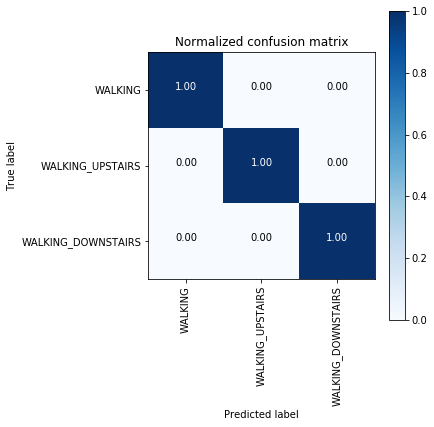

In [30]:
plt.figure(figsize=(6,6))
cm = confusion_matrix_cnn(y_train_dyn, model_dyn.predict(X_train_dyn),activities_dyn)
plot_confusion_matrix(cm, classes=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS'], 
                      normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Blues)
plt.show()

In [0]:
model_dyn.save('drive/My Drive/Data/Human_activity_recognition/model_dyn_class.h5')

## Final Prediction pipeline

In [0]:
from keras.models import load_model
import pickle
model_2class = load_model('drive/My Drive/Data/Human_activity_recognition/model_2class.h5')
model_static = load_model('drive/My Drive/Data/Human_activity_recognition/model_stat_class.h5')
model_dynamic = load_model('drive/My Drive/Data/Human_activity_recognition/model_dyn_class.h5')

In [0]:
 ##predicting whether dynamic or static
predict_2class = model_2class.predict(X_test)
Y_pred_2class =  np.argmax(predict_2class, axis=1)
#static data filter
X_static = X_test[Y_pred_2class==1]
#dynamic data filter
X_dynamic = X_test[Y_pred_2class==0]

In [0]:
#predicting static activities
predict_static = model_static.predict(X_static)
predict_static = np.argmax(predict_static,axis=1)
predict_static = predict_static + 4

In [0]:
#predicting dynamic activites
predict_dynamic = model_dynamic.predict(X_dynamic)
predict_dynamic = np.argmax(predict_dynamic,axis=1)
predict_dynamic = predict_dynamic + 1

In [0]:
#appending final output to one list in the same sequence of input data
i,j = 0,0 
final_pred = []
for mask in Y_pred_2class:
    if mask == 1:
        final_pred.append(predict_static[i])
        i = i + 1
    else:
        final_pred.append(predict_dynamic[j])
        j = j + 1 

## Evaluate Predictions

In [60]:
##accuracy of test
from sklearn.metrics import accuracy_score
print('Accuracy of test data',accuracy_score(y_test,final_pred))


Accuracy of test data 0.9419748897183576


In [61]:

#confusion metric
cm = confusion_matrix(y_test, final_pred,labels=range(1,7))
cm

array([[493,   0,   3,   0,   0,   0],
       [  0, 446,  25,   0,   0,   0],
       [  0,   0, 420,   0,   0,   0],
       [  0,   2,   0, 424,  60,   5],
       [  0,   3,   0,  73, 456,   0],
       [  0,   0,   0,   0,   0, 537]])